In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from core import events

In [2]:
epl = events(league=8)

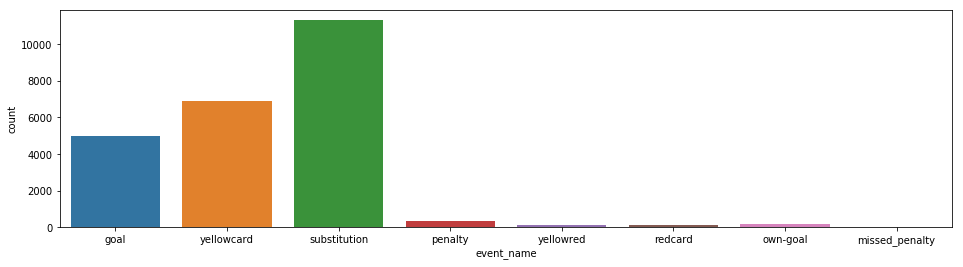

In [3]:
plt.figure(figsize=(16,4))
sns.countplot(epl['event_name'])

In [4]:
epl.head()

,fixture_id,starting_date,season,localname,localteam_score,visitorteam_score,visitorname,event_name,minute,extra_minute,reason,player,related_player,teamevent
0,464,2013-08-17,2013/2014,Liverpool,1,0,Stoke City,goal,37.0,NaN,None,Daniel Andre Sturridge,Iago Aspas Juncal,Liverpool
1,464,2013-08-17,2013/2014,Liverpool,1,0,Stoke City,yellowcard,44.0,NaN,None,Steven N'Kemboanza Mike Christopher N'Zonzi,None,Stoke City
2,464,2013-08-17,2013/2014,Liverpool,1,0,Stoke City,substitution,63.0,NaN,None,Charlie Adam,Glenn Whelan,Stoke City
3,464,2013-08-17,2013/2014,Liverpool,1,0,Stoke City,substitution,63.0,NaN,None,Jermaine Pennant,Matthew Etherington,Stoke City
4,464,2013-08-17,2013/2014,Liverpool,1,0,Stoke City,substitution,72.0,NaN,None,Raheem Shaquille Sterling,Iago Aspas Juncal,Liverpool


In [6]:
epl['goal_difference'] = epl['localteam_score'] - epl['visitorteam_score']

def outcome(goal_difference):
    if goal_difference > 0:
        return 'local'
    if goal_difference < 0:
        return 'visitor'
    return 'tie'

epl['outcome'] = epl['goal_difference'].apply(lambda x: outcome(x))

s2015 = epl[epl['season'] == '2016/2017']

#game result only
gs2015 = s2015[['fixture_id','localname', 'localteam_score','visitorteam_score','visitorname','outcome','season']].drop_duplicates()

#########
home = gs2015[['fixture_id','localname','localteam_score','outcome']]

def result_home(outcome):
    if outcome == 'local':
        return 'win'
    if outcome == 'visitor':
        return 'loss'
    return 'tie'
        

home['result'] = home['outcome'].apply(lambda x: result_home(x))
home['home_away'] = 'home'
home.columns = ['fixture_id','teamname','score','outcome','result','home_away']

#########

away = gs2015[['fixture_id','visitorname','visitorteam_score','outcome']]

def result_away(outcome):
    if outcome == 'visitor':
        return 'win'
    if outcome == 'local':
        return 'loss'
    return 'tie'
        

away['result'] = away['outcome'].apply(lambda x: result_away(x))
away['home_away'] = 'away'
away.columns = ['fixture_id','teamname','score','outcome','result','home_away']

allteams = home.append(away)
allteams.drop('outcome', axis=1, inplace=True)

x = allteams.groupby(['teamname','result']).count().reset_index().pivot('teamname','result','score').reset_index()
x['points'] = x['win']*3 + x['tie']*1
x['games'] = x['win']+x['tie']+x['loss']
x['pct_win'] = x['win'] / x['games']
x.sort_values('points', ascending=False).reset_index(drop=True)

result,teamname,loss,tie,win,points,games,pct_win
0,Chelsea,5,3,30,93,38,0.789474
1,Tottenham Hotspur,4,8,26,86,38,0.684211
2,Manchester City,5,9,23,78,37,0.621622
3,Arsenal,9,6,23,75,38,0.605263
4,Liverpool,6,10,21,73,37,0.567568
5,Manchester United,5,15,18,69,38,0.473684
6,Everton,11,10,17,61,38,0.447368
7,Southampton,16,10,12,46,38,0.315789
8,AFC Bournemouth,16,10,12,46,38,0.315789
9,West Bromwich Albion,17,9,12,45,38,0.315789
